the M87 "conversion constant" for this camera is:

$\Delta \Omega\!\times\!10^{23} = 5.88\!\times\!10^{-1}$

```bash
./igrmonty/test_sane.sh
```
runs every SANE row in the CSV (all spins, all timesteps).

```bash
./igrmonty/test_mad.sh
```
does the same for MAD.

add dump indices after the command to restrict the sweep (e.g.):
```bash
./igrmonty/test_sane.sh 4000 4200
```

to run everything in one go, call
```bash
./igrmonty/run_spectra.sh ALL
```
(or pass SANE/MAD directly if you don’t need the wrappers). the script still honors any extra dump filters.

all output spectra are named spectrum_<state+spin>_<dump>_<model>_pos<pos>.h5, and detailed logs plus the generated .par files live under `igrmonty/logs/` for auditing.

---

# `auto_munit_bracket.py` — command line flags (full notes)

### command example

```bash
python auto_munit_bracket.py --row 0 --ns 2e5 --resume --p-factor 3
```

---

# required flags

### `--row <index>`

selects which row of the model table CSV to tune.
rows correspond to entries in `munits_results.csv`.

### `--csv <path>`

path to the model table.
defaults to the script’s standard CSV (usually `munits_results.csv`).

---

# flux targets and comparison

### `--target-flux <Jy>`

desired flux at the target frequency.
default: **0.5 Jy** (M87 @ 230 GHz).

### `--freq-target <Hz>`

frequency in Hz at which flux is compared.
default: **230 GHz**.

### `--rel-tol <fraction>`

relative tolerance for convergence:

$\frac{|F_{\text{model}} - F_{\text{target}}|}{F_{\text{target}}} < \text{rel\_tol}$

default: 0.05 $\rightarrow$ 5%.

### `--abs-tol <Jy>`

absolute tolerance in Jy.
if set, overrides relative tolerance.
useful for flux $\ll$ 1 or $\gg$ 1 Jy.

---

# GRMONTY photon counts & physics

### `--ns <Ns>`

number of photons to trace in *each* GRMONTY trial.
higher $\rightarrow$ smoother spectra, slower runs.
typical for tuning: **2×10⁵**. **$2 \times 10^5$**

### `--fit-bias-ns <Ns>`

photons used **only during GRMONTY’s internal bias tuning**.
does not affect main shot.
default: 50,000.

### `--mbh <Msun>`

black hole mass in solar masses.
passed to GRMONTY as `MBH`.

### `--tp-over-te <ratio>`

ion-to-electron temperature ratio:

$T_p / T_e.$

default: 3.0.

---

# bias configuration

### `--bias <initial>`

initial scattering bias guess passed to GRMONTY.
closer guess $\rightarrow$ faster bias tuning.
default: 0.05.

### `--target-ratio <R>`

target effectiveness ratio used by GRMONTY’s bias tuner.
default: ($\sqrt{2}$).
controls optimal weight distribution for scattering events.

### `--invalid-bias-max <N>`

maximum number of “invalid bias” warnings allowed before declaring the trial unstable.
default: 200.

### `--bias-backoff-factor <factor>`

if a trial is unstable (too many invalid-bias events), M_unit is reduced by:

$M_{\text{new}} = \frac{M_{\text{old}}}{\text{bias\_backoff\_factor}}.$

default: 5.0.

---

# M_unit bracketing & update rules

### `--p-factor <P>`

exponent in the power-law update rule:

$M_{\text{new}} = M_{\text{old}} \left(\frac{F_{\text{target}}}{F_{\text{old}}}\right)^{1/P}$

larger P $\rightarrow$ gentler, safer adjustments.
typical values: 2–3.

### `--min-munit` / `--max-munit`

hard lower and upper bounds for M_unit search region.
prevent runaway scaling.

* default min: ($10^{20}$) g
* default max: ($10^{32}$) g

### `--max-iters <N>`

maximum number of new GRMONTY trials.
each iteration updates M_unit and re-runs GRMONTY.
default: 8.

---

# runtime behavior & files

### `--grmonty-bin <path>`

path to the GRMONTY executable used for all trials.

### `--resume`

resume mode:

* reuses existing spectra/logs/parfiles
* avoids re-running completed trials
* restarts tuning from last successful result

essential when jobs crash or checkpoints exist.

### `--keep-trials`

do **not** delete intermediate files:

* trial parfiles
* logs
* spectra

useful for debugging or manual inspection.

### `--history-csv <path>`

CSV file where each tuning trial is recorded.
stores trial info: M_unit, flux, bias, status, etc.
default: something like `munits_tuning_history.csv`.

---


In [ ]:
# inspect .h5 output file using something like:
import h5py

path = '/work/vmo703/igrmonty_outputs/m87/spectrum_Sa-0.5_4000_RBETA_pos0.h5'
with h5py.File(path, 'r') as f:
    print("top-level groups:", list(f.keys()))
    print("\noutput group contents:")
    def walk(name, obj):
        if isinstance(obj, h5py.Dataset):
            print("  [dataset]", name)
        elif isinstance(obj, h5py.Group):
            print("  [group]", name)
    f['output'].visititems(walk)


top-level groups: ['fluid_header', 'output', 'params']

output group contents:
  [dataset] L
  [dataset] LEdd
  [dataset] Lcomponent
  [dataset] Mdot
  [dataset] MdotEdd
  [dataset] Nmade
  [dataset] Nrecorded
  [dataset] Nscattered
  [dataset] dOmega
  [dataset] efficiency
  [dataset] lnu
  [dataset] nscatt
  [dataset] nuLnu
  [dataset] tau_abs
  [dataset] tau_scatt
  [dataset] x1av
  [dataset] x2av
  [dataset] x3av


In [7]:
# inspect params in .h5 output file using:
import h5py

spec = "/work/vmo703/igrmonty_outputs/m87/spectrum_Sa-0.5_4000_RBETA_pos0.h5"

with h5py.File(spec, "r") as f:
    grp = f["/params"]

    print("params in this grmonty file:\n")

    # datasets
    for key in grp.keys():
        name = key.decode() if isinstance(key, bytes) else str(key)
        try:
            val = grp[name][()]
        except Exception:
            continue
        # decode bytes inside datasets
        if isinstance(val, bytes):
            val = val.decode()
        print(f"{name:<20} = {val}")

    # attributes
    for key, val in grp.attrs.items():
        name = key.decode() if isinstance(key, bytes) else str(key)
        if isinstance(val, bytes):
            val = val.decode()
        print(f"{name:<20} = {val}")


params in this grmonty file:

BREMSSTRAHLUNG       = 1
B_unit               = 1341.034034857332
COMPTON              = 1
DIST_KAPPA           = 0
DLNU                 = 0.18420680743952364
GAMMACUT             = 1000.0
KAPPA                = 4.0
LNUMAX               = 55.262042231857095
LNUMIN               = 18.420680743952367
L_unit               = 960076745496757.0
MBH                  = 1.29285e+43
M_unit               = 1.40911417e+29
N1                   = 288
N2                   = 128
N3                   = 128
NUCUT                = 50000000000000.0
NUMAX                = 1e+24
NUMIN                = 100000000.0
N_EBINS              = 200
N_ESAMP              = 200
N_THBINS             = 18
Ne_unit              = 95146790.07370181
Ns                   = 200000
RHO_unit             = 1.5923125956548047e-16
Rin                  = 1.6511440856012218
Rout                 = 1000.0
SYNCHROTRON          = 1
THETAE_MAX           = 1000.0
THETAE_MIN           = 0.001
TP_OVER_TE        

### GRMONTY spectrum output parameter table

| **parameter**      | **value** | **interpretation / meaning**                                      |
| ------------------ | --------- | ----------------------------------------------------------------- |
| **BREMSSTRAHLUNG** | `1`       | bremsstrahlung emission enabled.                                  |
| **SYNCHROTRON**    | `1`       | synchrotron emission enabled.                                     |
| **COMPTON**        | `1`       | compton scattering enabled.                                       |
| **DIST_KAPPA**     | `0`       | distribution type = thermal (not kappa distribution).             |
| **KAPPA**          | `4.0`     | kappa index (ignored unless DIST_DAPPA $\neq$ 0).                 |
| **GAMMACUT**       | `1000.0`  | high-energy electron cutoff (lorentz factor).                     |
| **THETAE_MIN**     | `1e-3`    | minimum allowed $\theta_e$ when sampling the distribution.        |
| **THETAE_MAX**     | `1000.0`  | maximum allowed $\theta_e.$                                       |
| **TP_OVER_TE**     | `3.0`     | ratio of ion to electron temperature (Tp/Te).                     |
| **Thetae_unit**    | `244.82`  | electron temperature unit = $\theta_e$ scaling from MHD snapshot. |

---

### grid, frequency sampling, and resolution

| parameter    | value | interpretation                                               |
| ------------ | ----- | ------------------------------------------------------------ |
| **N1**       | `288` | number of grid points in radial direction (from GRMHD dump). |
| **N2**       | `128` | number of points in polar direction.                         |
| **N3**       | `128` | number of points in azimuth.                                 |
| **N_EBINS**  | `200` | number of energy bins in the spectrum.                       |
| **N_ESAMP**  | `200` | number of electron samples per emission event.               |
| **N_THBINS** | `18`  | number of theta bins for angle-dependent spectra.            |

---

### frequency grid

| parameter  | value     | interpretation                   |
| ---------- | --------- | -------------------------------- |
| **NUMIN**  | `1e8`     | minimum photon frequency [Hz].   |
| **NUMAX**  | `1e24`    | maximum photon frequency [Hz].   |
| **LNUMIN** | `18.4207` | $log_{10}$(NUMIN).               |
| **LNUMAX** | `55.2620` | $log_{10}$(NUMAX).               |
| **DLNU**   | `0.1842`  | step size in log frequency grid. |

---

### units derived from GRMHD dump + chosen M_unit

| parameter    | value           | interpretation                                                    |
| ------------ | --------------- | ----------------------------------------------------------------- |
| **L_unit**   | `9.600767×10¹⁴` | luminosity unit. very small because your M_unit is large.         |
| **T_unit**   | `3.202×10⁴`     | time unit = $GM/c^3$ in seconds.                                  |
| **U_unit**   | `1.431099×10⁵`  | internal energy unit from scaling.                                |
| **B_unit**   | `1341.03`       | magnetic field scaling from simulation $\rightarrow$ physical B.  |
| **Ne_unit**  | `9.5147×10⁷`    | electron number density unit.                                     |
| **RHO_unit** | `1.59231×10⁻¹⁶` | mass density unit.                                                |

---

the most important:

$\mathbf{M_{unit}} = 1.409 \times 10^{29}$

this is the mass scaling **actually used by GRMONTY** for this spectrum.

---

### photon statistics & bias

| parameter      | value       | interpretation                                                          |
| -------------- | ----------- | ----------------------------------------------------------------------- |
| **Ns**         | `200000`    | number of monte-carlo photons traced.                                   |
| **bias**       | `3.5728889` | final tuned bias for scattering $\rightarrow$ controls event weighting. |
| **WEIGHT_MIN** | `1e28`      | minimum photon weight before russian roulette termination.              |

---

### geometry, model metadata

| parameter  | value                                            | interpretation                                                              |
| ---------- | ------------------------------------------------ | --------------------------------------------------------------------------- |
| **a**      | `-0.5`                                           | black hole spin. negative $\rightarrow$ retrograde.                         |
| **Rin**    | `1.651`                                          | inner radial cutoff.                                                        |
| **Rout**   | `1000.0`                                         | outer simulation radius sampled.                                            |
| **hslope** | `0.3`                                            | used by iharm coordinates: warp between Kerr-Schild & modified Kerr-Schild. |
| **model**  | `"iharm"`                                        | indicates emission model + dump format (IHARM3D).                           |
| **dump**   | `/work/vmo703/grmhd_dump_samples/Sa-0.5_4000.h5` | the GRMHD snapshot this spectrum came from.                                 |
| **t**      | `0.0`                                            | simulation time of this snapshot (in code units).                           |

---


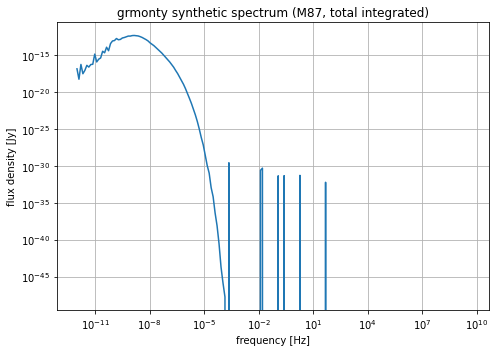

In [ ]:
# plot sed from .h5 output file with something like:
import h5py
import numpy as np
import matplotlib.pyplot as plt

path = '/work/vmo703/igrmonty_outputs/m87/spectrum_Sa-0.5_4000_RBETA_pos0.h5'
with h5py.File(path, 'r') as f:
    out = f['output']
    lognu = out['lnu'][:]       # shape (200,)
    nuLnu = out['nuLnu'][:]     # shape (8,200,18)

# choose component 0 = total luminosity (usually)
# sum over theta bins for full-sky integrated spectrum
nuLnu_total = np.sum(nuLnu[0, :, :], axis=-1)

# convert back to 1-D arrays
nu = 10**lognu
Lnu = nuLnu_total / nu  # erg/s/Hz

# convert to flux density (Jy) at D = 16.8 Mpc for M87
D = 16.8 * 3.086e24  # cm
Fnu = Lnu / (4 * np.pi * D**2) / 1e-23  # Jy

plt.figure(figsize=(7,5))
plt.loglog(nu, Fnu)
plt.xlabel('frequency [Hz]')
plt.ylabel('flux density [Jy]')
plt.title('grmonty synthetic spectrum (M87, total integrated)')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()


In [ ]:
# brent's method for 1D minimization
from scipy.optimize import minimize_scalar

def objective(M):
    flux = run_grmonty_with_munit(M)
    return (flux - target_flux)**2

result = minimize_scalar(objective, bounds=(M_low, M_high), method='bounded')

best_Munit = result.x


In [ ]:
# for multi-frequency matching
def objective(M):
    f86, f230 = run_fluxes(M)
    return (f86 - 0.8)**2 + (f230 - 0.8)**2
